# Hyperparameter Tuning Using PSO

#### In this notebook, we present the implementation of the hyperparameter search using particle swarm optimization (PSO). After the best hyperparameters for each model are found, training and evaluation are performed

Install necessary dependencies

In [1]:
!pip install -r ../req.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.4 MB/s eta 0:00:00


Start with the existing pipeline

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
from pyswarms.single import GlobalBestPSO
from functools import partial
from typing import Dict, List, Tuple, Union, Optional


# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


class ModelPipeline:
    """
    A flexible, modular pipeline for feature selection,
    models tuning, and training.

    Attributes:
        data_path (str): path to the dataset (Pandas parquet)
        sample_frac (float): part of a dataset used for training
        X (np.array): feature vectors
        Y (np.array): labels
        selected_features (List[str]): list of selected features
        scaler ()
        X_train, X_test, y_train, y_test (np.array's): train and test dataset splits
        models (List[Dict]): list of dictionaries describing models
    """

    def __init__(self, data_path: str, selected_features=None, sample_frac: float = 1.0):
        """Initialize the pipeline with data loading"""
        self.data_path = data_path
        self.sample_frac = sample_frac
        self.selected_features = selected_features
        self._load_data()
        self.scaler = None
        self.models = {
            'RandomForest': {
                'tune_func': self.tune_random_forest,
                'train_func': self.train_random_forest,
                'params': None
            },
            'XGBoost': {
                'tune_func': self.tune_xgboost,
                'train_func': self.train_xgboost,
                'params': None
            },
            'LightGBM': {
                'tune_func': self.tune_lightgbm,
                'train_func': self.train_lightgbm,
                'params': None
            },
            'DenseNN': {
                'tune_func': self.tune_dense_nn,
                'train_func': self.train_dense_nn,
                'params': None
            }
        }

    def _random_undersample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """Undersample dataset for binary labels"""
        a_label, b_label = y.unique()
        a_label_cnt, b_label_cnt = y.value_counts()
        minority_label = a_label if (a_label_cnt < b_label_cnt) else b_label
        majority_label = b_label if (a_label_cnt < b_label_cnt) else a_label
        minority_cnt = a_label_cnt if (a_label_cnt < b_label_cnt) else b_label_cnt

        # Select all elements with minority label
        minority_y = y[y == minority_label]
        new_X = X.loc[minority_y.index]
        new_y = minority_y

        # Sample elements with majority label
        majority_y = y[y == majority_label]
        sampled_majority = majority_y.sample(n=minority_cnt, random_state=42)
        new_X = pd.concat([new_X, X.loc[sampled_majority.index]])
        new_y = pd.concat([new_y, sampled_majority])

        return new_X, new_y

    def _load_data(self) -> None:
        """Load and prepare data"""
        X = pd.read_parquet(self.data_path)
        y = X['remainder__isFraud']
        X = X.drop(columns=['remainder__isFraud'])

        """Prepare train/test split and optionally select features"""
        if self.selected_features is not None:
            X = X.iloc[:, self.selected_features]

        self.X = X
        self.y = y

        # Data split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Undersampling for equal proportion of labels
        self.X_train, self.y_train = self._random_undersample(X_train, y_train)
        self.X_test, self.y_test = X_test, y_test

        # Take a sample using sample_frac
        if self.sample_frac < 1.0:
            self.X_train = self.X_train.sample(frac=self.sample_frac, random_state=42)
            self.y_train = self.y_train.loc[self.X_train.index]

    def evaluate_features(self, individual, X_train, y_train, X_val, y_val) -> Tuple[float]:
        """Evaluate fitness of feature subset using RandomForest"""
        selected = [i for i, val in enumerate(individual) if val == 1]

        if not selected:  # At least one feature must be selected
            return 0.0,

        X_train_sub = X_train.iloc[:, selected]
        X_val_sub = X_val.iloc[:, selected]

        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=5,
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_train_sub, y_train)
        y_proba = model.predict_proba(X_val_sub)[:, 1]
        score = roc_auc_score(y_val, y_proba)

        # Add penalty for too many features
        feature_penalty = len(selected) / X_train.shape[1] * 0.1
        return score - feature_penalty,

    def genetic_feature_selection(self, n_pop: int = 50, n_gen: int = 20,
                                  cxpb: float = 0.5, mutpb: float = 0.2) -> List[int]:
        """Perform feature selection using Genetic Algorithm"""
        # Split data for feature selection
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=42
        )

        # DEAP setup
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_bool, n=self.X.shape[1])
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        eval_fn = partial(self.evaluate_features,
                          X_train=X_train, y_train=y_train,
                          X_val=X_val, y_val=y_val)
        toolbox.register("evaluate", eval_fn)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Run GA
        pop = toolbox.population(n=n_pop)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaSimple(
            pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=n_gen,
            stats=stats, halloffame=hof, verbose=True
        )

        best_individual = hof[0]
        selected_features = [i for i, val in enumerate(best_individual) if val == 1]

        print(f"\nSelected {len(selected_features)} features out of {self.X.shape[1]}")
        print("Selected feature indices:", selected_features)

        self.selected_features = selected_features
        return selected_features

    # ==================== Random Forest ====================
    def tune_random_forest(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for Random Forest hyperparameters"""

        bounds = (
            np.array([50, 2, 2, 1]),    # min values
            np.array([500, 30, 10, 30])  # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                n_estimators = int(param_set[0])
                max_depth = int(param_set[1])
                min_samples_split = int(param_set[2])
                max_features = min(int(param_set[3]), self.X_train.shape[1])

                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    class_weight='balanced_subsample',
                    n_jobs=-1,
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'n_estimators': int(best_params[0]),
            'max_depth': int(best_params[1]),
            'min_samples_split': int(best_params[2]),
            'max_features': int(best_params[3])
        }

        print("\nOptimized Random Forest Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['RandomForest']['params'] = optimized_params
        return optimized_params

    def train_random_forest(self) -> Dict[str, Union[float, str]]:
        """Train Random Forest with optimized parameters"""
        if not self.models['RandomForest']['params']:
            raise ValueError("Random Forest parameters not tuned. Call tune_random_forest() first.")

        params = self.models['RandomForest']['params']
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            max_features=params['max_features'],
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "Random Forest")

    # ==================== XGBoost ====================
    def tune_xgboost(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for XGBoost hyperparameters"""

        bounds = (
            np.array([0.01, 3, 0.1, 0.1, 0.1, 0]),  # min values
            np.array([0.3, 10, 10, 1, 1, 5])        # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = XGBClassifier(
                    learning_rate=param_set[0],
                    max_depth=int(param_set[1]),
                    min_child_weight=param_set[2],
                    subsample=param_set[3],
                    colsample_bytree=param_set[4],
                    gamma=param_set[5],
                    scale_pos_weight=np.sqrt(len(self.y_train)/self.y_train.sum()),
                    tree_method='hist',
                    eval_metric='aucpr',
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'max_depth': int(best_params[1]),
            'min_child_weight': best_params[2],
            'subsample': best_params[3],
            'colsample_bytree': best_params[4],
            'gamma': best_params[5]
        }

        print("\nOptimized XGBoost Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['XGBoost']['params'] = optimized_params
        return optimized_params

    def train_xgboost(self) -> Dict[str, Union[float, str]]:
        """Train XGBoost with optimized parameters"""
        if not self.models['XGBoost']['params']:
            raise ValueError("XGBoost parameters not tuned. Call tune_xgboost() first.")

        params = self.models['XGBoost']['params']
        model = XGBClassifier(
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            min_child_weight=params['min_child_weight'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            gamma=params['gamma'],
            scale_pos_weight=np.sqrt(len(self.y_train)/self.y_train.sum()),
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "XGBoost")

    # ==================== LightGBM ====================
    def tune_lightgbm(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for LightGBM hyperparameters"""

        bounds = (
            np.array([0.01, 3, 0.1, 0.1, 0.1, 20]),  # min values
            np.array([0.3, 50, 100, 1, 1, 50])       # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = LGBMClassifier(
                    learning_rate=param_set[0],
                    num_leaves=int(param_set[1]),
                    min_data_in_leaf=int(param_set[2]),
                    feature_fraction=param_set[3],
                    bagging_fraction=param_set[4],
                    bagging_freq=int(param_set[5]),
                    class_weight='balanced',
                    boosting_type='gbdt',
                    objective='binary',
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'num_leaves': int(best_params[1]),
            'min_data_in_leaf': int(best_params[2]),
            'feature_fraction': best_params[3],
            'bagging_fraction': best_params[4],
            'bagging_freq': int(best_params[5])
        }

        print("\nOptimized LightGBM Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['LightGBM']['params'] = optimized_params
        return optimized_params

    def train_lightgbm(self) -> Dict[str, Union[float, str]]:
        """Train LightGBM with optimized parameters"""
        if not self.models['LightGBM']['params']:
            raise ValueError("LightGBM parameters not tuned. Call tune_lightgbm() first.")

        params = self.models['LightGBM']['params']
        model = LGBMClassifier(
            learning_rate=params['learning_rate'],
            num_leaves=params['num_leaves'],
            min_data_in_leaf=params['min_data_in_leaf'],
            feature_fraction=params['feature_fraction'],
            bagging_fraction=params['bagging_fraction'],
            bagging_freq=params['bagging_freq'],
            class_weight='balanced',
            boosting_type='gbdt',
            objective='binary',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "LightGBM")

    # ==================== Dense Neural Network ====================
    def _create_dense_nn(self, input_dim: int, layers: Tuple[int, ...] = (64, 32),
                         learning_rate: float = 0.001, dropout_rate: float = 0.2) -> Sequential:
        """Create a dense neural network architecture"""
        model = Sequential()
        model.add(Input((input_dim,)))
        model.add(Dense(layers[0], activation='relu'))
        model.add(Dropout(dropout_rate))

        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def tune_dense_nn(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for Dense NN hyperparameters"""

        # Scale data for NN
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(self.X_train)

        bounds = (
            np.array([0.0001, 16, 16, 0.1, 0.1]),  # min values
            np.array([0.01, 256, 256, 0.5, 0.5])   # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = KerasClassifier(
                    model=lambda: self._create_dense_nn(
                        input_dim=X_train_scaled.shape[1],
                        layers=(int(param_set[1]), int(param_set[2])),
                        learning_rate=param_set[0],
                        dropout_rate=param_set[4]
                    ),
                    epochs=10,
                    batch_size=256,
                    verbose=0
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(X_train_scaled, self.y_train):
                    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'layer1': int(best_params[1]),
            'layer2': int(best_params[2]),
            'dropout_rate': best_params[4]
        }

        print("\nOptimized Dense NN Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['DenseNN']['params'] = optimized_params
        return optimized_params

    def train_dense_nn(self) -> Dict[str, Union[float, str]]:
        """Train Dense NN with optimized parameters"""
        if not self.models['DenseNN']['params']:
            raise ValueError("Dense NN parameters not tuned. Call tune_dense_nn() first.")

        params = self.models['DenseNN']['params']

        # Scale data
        X_train_scaled = self.scaler.transform(self.X_train)

        model = KerasClassifier(
            model=lambda: self._create_dense_nn(
                input_dim=X_train_scaled.shape[1],
                layers=(params['layer1'], params['layer2']),
                learning_rate=params['learning_rate'],
                dropout_rate=params['dropout_rate']
            ),
            epochs=50,
            batch_size=256,
            verbose=0
        )

        model.fit(X_train_scaled, self.y_train)
        return self._evaluate_model(model, "Dense Neural Network", is_nn=True)

    # ==================== Evaluation ====================
    def _evaluate_model(self, model, model_name: str, is_nn: bool = False,
                        X_test: Optional[np.ndarray] = None) -> Dict[str, Union[float, str]]:
        """Evaluate model performance and create visualizations"""
        if X_test is None:
            X_test = self.X_test

        if is_nn:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba > 0.5).astype(int)
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

        # Metrics calculation
        metrics = {
            "roc_auc": roc_auc_score(self.y_test, y_proba),
            "pr_auc": average_precision_score(self.y_test, y_proba),
            "classification_report": classification_report(self.y_test, y_pred)
        }

        if not is_nn and hasattr(model, 'feature_importances_'):
            metrics["feature_importance"] = model.feature_importances_

        # Visualization
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ConfusionMatrixDisplay.from_predictions(self.y_test, y_pred, ax=ax[0])
        ax[0].set_title(f"Confusion Matrix - {model_name}")

        if not is_nn and hasattr(model, 'feature_importances_'):
            # Top 10 most valuable features
            top_features = self.X.columns[
                np.argsort(metrics.get('feature_importance', np.zeros(self.X.shape[1])))[-10:]
            ]
            ax[1].barh(top_features, metrics.get('feature_importance', np.zeros(self.X.shape[1]))[-10:])
            ax[1].set_title(f"Top 10 Features - {model_name}")
        else:
            ax[1].axis('off')

        fig.tight_layout()

        plt.show()

        return metrics

    def run_pipeline(self, models_to_run: List[str] = None,
                     selected_features: List[int] = None) -> Dict[str, Dict[str, Union[float, str]]]:
        """
        Run the complete pipeline with optional model selection

        Args:
            models_to_run: List of model names to run (None for all)
            feature_selection: Whether to perform feature selection

        Returns:
            Dictionary of results for each model
        """
        if models_to_run is None:
            models_to_run = list(self.models.keys())

        # Perform feature selection if requested
        if selected_features is None:
            self.selected_features = list(range(self.X.shape[1]))

        results = {}

        for model_name in models_to_run:
            if model_name not in self.models:
                print(f"Warning: Model {model_name} not found in available models. Skipping.")
                continue

            print(f"\n=== Processing {model_name} ===")

            # Tune hyperparameters
            print(f"Tuning {model_name} hyperparameters...")
            self.models[model_name]['tune_func']()

            # Train model with optimized parameters
            print(f"Training {model_name} with optimized parameters...")
            results[model_name] = self.models[model_name]['train_func']()

            # Print results
            print(f"\n{model_name} Results:")
            print(f"ROC-AUC: {results[model_name]['roc_auc']:.4f}")
            print(f"PR-AUC: {results[model_name]['pr_auc']:.4f}")
            print("Classification Report:")
            print(results[model_name]['classification_report'])

        return results


Features obtained from GA feature selection

In [2]:
features = [2, 4, 8, 9, 12, 13, 14, 15, 16, 23, 24, 27, 28, 34, 37, 39, 45, 47, 49, 51, 52, 53, 56, 58, 59, 60, 61, 62, 65, 67, 68, 70, 72, 73, 74, 75, 76, 78, 80, 81, 82, 86, 88, 90, 93, 94, 98, 100, 101, 105, 109, 110, 114, 117, 119, 120, 122, 124, 125, 126, 127, 128, 133, 135, 136, 144, 153, 156, 158, 159, 160, 167, 169, 173, 177, 179, 180, 182, 184, 185, 187, 188, 189, 190, 195, 198, 202, 206, 208, 209, 210, 212, 216, 223, 227, 230, 234, 236, 239, 246, 247, 251, 255, 261, 264, 266, 269, 272, 277, 280, 282, 283, 284, 286, 288, 290, 293, 296, 300, 303, 307, 311, 313, 314, 315, 319, 320, 321, 323, 324, 325, 329, 334, 339, 342, 347, 348, 352, 353, 355, 358, 361, 366, 368, 369, 370, 371, 373, 378, 382, 384, 386, 387, 389, 391]

### Hyperparameter Tuning and Evaluation using Undersampling

In [3]:
pipeline_balanced = ModelPipeline(
    data_path='fraud_data.parquet',
    sample_frac=0.3
)

Random Forest Evaluation

2025-04-15 08:50:04,315 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3}



=== Processing RandomForest ===
Tuning RandomForest hyperparameters...


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.894
2025-04-15 09:04:19,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.894091809110226, best pos: [478.44753951  26.94722093   5.43889144  28.15059517]



Optimized Random Forest Parameters:
{'n_estimators': 478, 'max_depth': 26, 'min_samples_split': 5, 'max_features': 28}
Best ROC-AUC: 0.8941
Training RandomForest with optimized parameters...


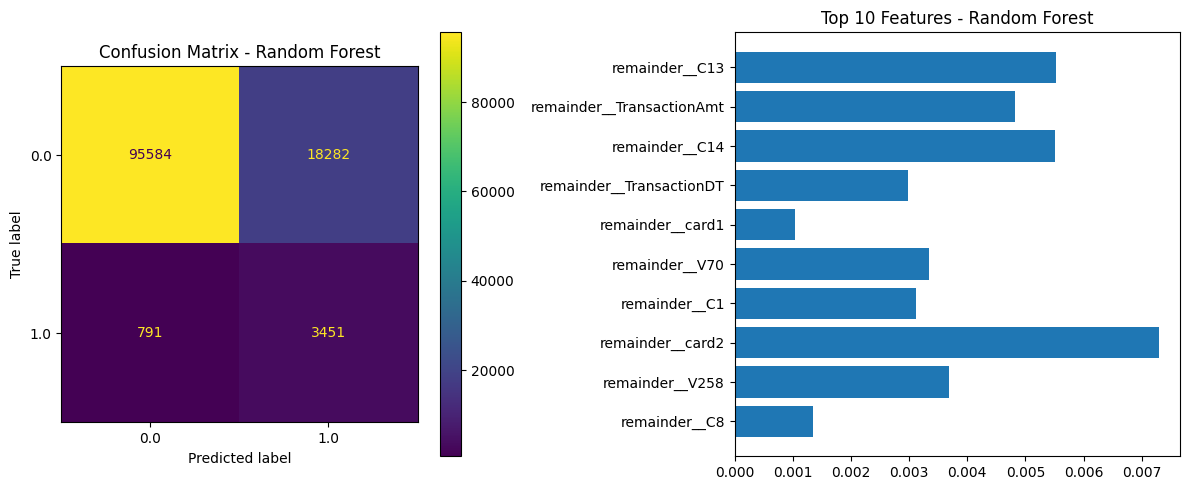


RandomForest Results:
ROC-AUC: 0.9045
PR-AUC: 0.5389
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91    113866
         1.0       0.16      0.81      0.27      4242

    accuracy                           0.84    118108
   macro avg       0.58      0.83      0.59    118108
weighted avg       0.96      0.84      0.89    118108



In [4]:
results_rf_balanced = pipeline_balanced.run_pipeline(
    models_to_run=[
        'RandomForest'
    ],
    selected_features=features
)

XGBoost Evaluation

2025-04-15 09:07:20,611 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3}



=== Processing XGBoost ===
Tuning XGBoost hyperparameters...


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.907
2025-04-15 09:12:30,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9068439254841705, best pos: [0.28401961 7.8029476  6.17243871 0.98841606 0.88788678 0.32766076]



Optimized XGBoost Parameters:
{'learning_rate': np.float64(0.28401960527716236), 'max_depth': 7, 'min_child_weight': np.float64(6.172438714409442), 'subsample': np.float64(0.9884160626446158), 'colsample_bytree': np.float64(0.8878867794274299), 'gamma': np.float64(0.3276607618022003)}
Best ROC-AUC: 0.9068
Training XGBoost with optimized parameters...


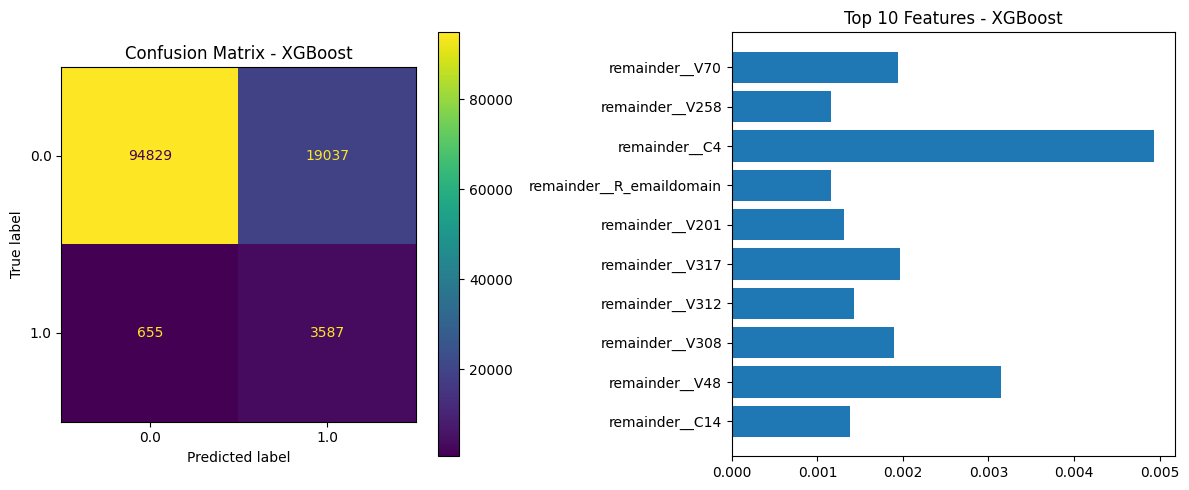


XGBoost Results:
ROC-AUC: 0.9175
PR-AUC: 0.5607
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91    113866
         1.0       0.16      0.85      0.27      4242

    accuracy                           0.83    118108
   macro avg       0.58      0.84      0.59    118108
weighted avg       0.96      0.83      0.88    118108



In [5]:
results_xg_balanced = pipeline_balanced.run_pipeline(
    models_to_run=[
        'XGBoost'
    ],
    selected_features=features
)

LightGBM Evaluation

2025-04-15 09:12:36,455 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3}



=== Processing LightGBM ===
Tuning LightGBM hyperparameters...


pyswarms.single.global_best:   0%|          |0/10

[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22
[LightGBM] [Warning] feature_fraction is set=0.5096981341736211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5096981341736211
[LightGBM] [Warning] bagging_fraction is set=0.11045848591729057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11045848591729057
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22
[LightGBM] [Warning] feature_fraction is set=0.5096981341736211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5096981341736211

pyswarms.single.global_best:  10%|█         |1/10, best_cost=-0.898

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_freq is set=22, subsample_freq=0 will be ignored. Current value: bagging_freq=22
[LightGBM] [Warning] feature_fraction is set=0.4155642380882627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4155642380882627
[LightGBM] [Warning] bagging_fraction is set=0.12988279791222992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12988279791222992
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28
[LightGBM] [Warning] feature_fraction is set=0.19818883357264397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19818883357264397
[LightGBM] [Warning] bagging_fraction is set=0.9207806157186312, subsample=1.0 

pyswarms.single.global_best:  20%|██        |2/10, best_cost=-0.905

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] bagging_freq is set=26, subsample_freq=0 will be ignored. Current value: bagging_freq=26
[LightGBM] [Warning] feature_fraction is set=0.16579872224691697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16579872224691697
[LightGBM] [Warning] bagging_fraction is set=0.2675376971341912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2675376971341912
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34
[LightGBM] [Warning] feature_fraction is set=0.7278304630317646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7278304630317646
[LightGBM] [Warning] bagging_fraction is set=0.7500705325398379, subsample=1.0 

pyswarms.single.global_best:  30%|███       |3/10, best_cost=-0.905

[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] feature_fraction is set=0.7578571644959474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7578571644959474
[LightGBM] [Warning] bagging_fraction is set=0.43098490789129806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43098490789129806
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=37, subsample_freq=0 will be ignored. Current value: bagging_freq=37
[LightGBM] [Warning] feature_fraction is set=0.12277877338549961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12277877338549961
[LightGBM] [Warning] bagging_fraction is set=0.5972801333706336, subsample=1.

pyswarms.single.global_best:  40%|████      |4/10, best_cost=-0.905

[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34
[LightGBM] [Warning] bagging_freq is set=33, subsample_freq=0 will be ignored. Current value: bagging_freq=33
[LightGBM] [Warning] feature_fraction is set=0.3128888811540472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3128888811540472
[LightGBM] [Warning] bagging_fraction is set=0.6338926310803867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6338926310803867
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=38, subsample_freq=0 will be ignored. Current value: bagging_freq=38
[LightGBM] [Warning] feature_fraction is set=0.4072665900050043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4072665900050043
[LightGBM] [Warning] bagging_fraction is set=0.4714005072956694, subsample=1.0 wi

pyswarms.single.global_best:  50%|█████     |5/10, best_cost=-0.905

[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=34, subsample_freq=0 will be ignored. Current value: bagging_freq=34
[LightGBM] [Warning] feature_fraction is set=0.7766410747238162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766410747238162
[LightGBM] [Warning] bagging_fraction is set=0.8073233386215419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073233386215419
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] bagging_freq is set=35, subsample_freq=0 will be ignored. Current value: bagging_freq=35
[LightGBM] [Warning] feature_fraction is set=0.6280476067044604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6280476067044604
[LightGBM] [Warning] bagging_fraction is set=0.5505931365030626, subsample=1.0 wi

pyswarms.single.global_best:  60%|██████    |6/10, best_cost=-0.905

[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] bagging_freq is set=33, subsample_freq=0 will be ignored. Current value: bagging_freq=33
[LightGBM] [Warning] feature_fraction is set=0.1791653401415935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1791653401415935
[LightGBM] [Warning] bagging_fraction is set=0.9823963517319954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9823963517319954
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=28, subsample_freq=0 will be ignored. Current value: bagging_freq=28
[LightGBM] [Warning] feature_fraction is set=0.574486368492484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574486368492484
[LightGBM] [Warning] bagging_fraction is set=0.5740472542037539, subsample=1.0 will

pyswarms.single.global_best:  70%|███████   |7/10, best_cost=-0.906

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value

pyswarms.single.global_best:  80%|████████  |8/10, best_cost=-0.906

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] feature_fraction is set=0.6694979176969308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6694979176969308
[LightGBM] [Warning] bagging_fraction is set=0.6893240669443793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6893240669443793
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] bagging_freq is set=49, subsample_freq=0 will be ignored. Current value: bagging_freq=49
[LightGBM] [Warning] feature_fraction is set=0.16994115708287333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16994115708287333
[LightGBM] [Warning] bagging_fraction is set=0.5970373030780004, subsample=1.0 

pyswarms.single.global_best:  90%|█████████ |9/10, best_cost=-0.906

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.906
2025-04-15 09:15:04,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9062353678506493, best pos: [ 0.21926592 24.22562921 37.99504906  0.42471319  0.98590256 29.87415142]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

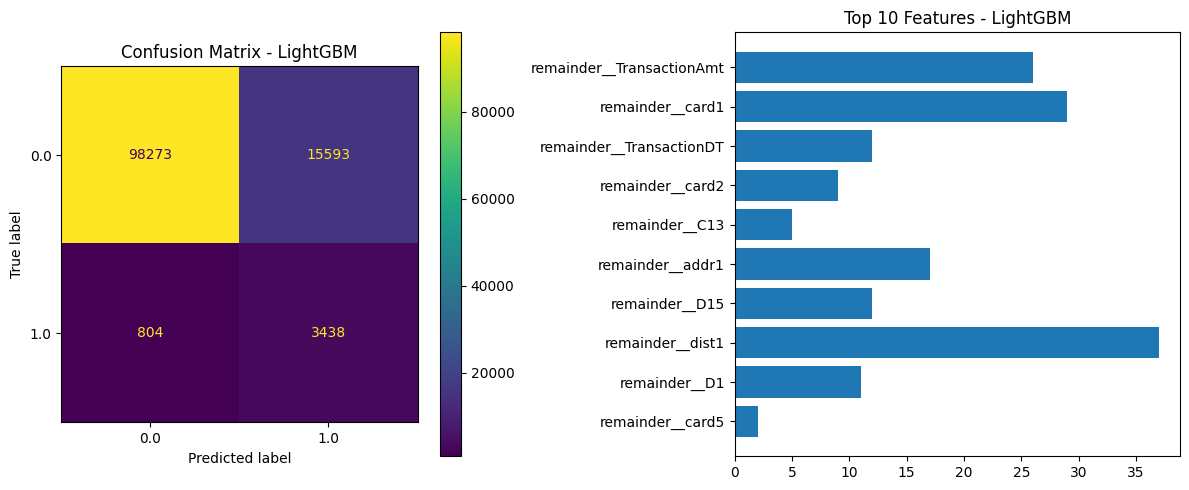


LightGBM Results:
ROC-AUC: 0.9129
PR-AUC: 0.5578
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    113866
         1.0       0.18      0.81      0.30      4242

    accuracy                           0.86    118108
   macro avg       0.59      0.84      0.61    118108
weighted avg       0.96      0.86      0.90    118108



In [6]:
results_light_balanced = pipeline_balanced.run_pipeline(
    models_to_run=[
        'LightGBM'
    ],
    selected_features=features
)

Dense Neural Network Evaluation

2025-04-15 09:15:09,670 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3}



=== Processing DenseNN ===
Tuning DenseNN hyperparameters...


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.873
2025-04-15 09:27:25,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8729454894106151, best pos: [5.60178584e-03 2.10971752e+02 1.44448134e+02 3.59488858e-01
 1.51780116e-01]



Optimized Dense NN Parameters:
{'learning_rate': np.float64(0.005601785837764509), 'layer1': 210, 'layer2': 144, 'dropout_rate': np.float64(0.15178011585806242)}
Best ROC-AUC: 0.8729
Training DenseNN with optimized parameters...


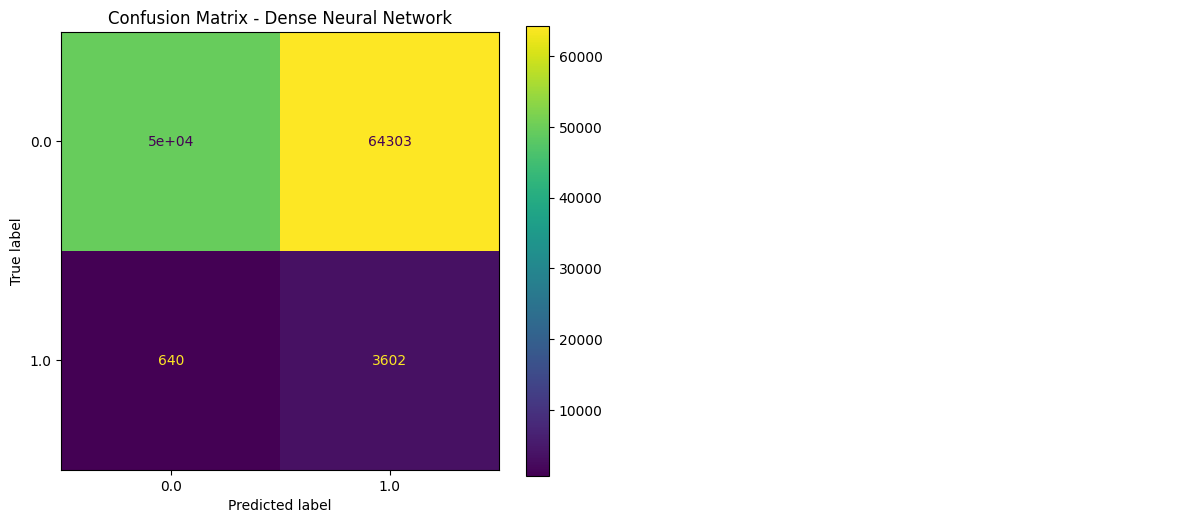


DenseNN Results:
ROC-AUC: 0.7548
PR-AUC: 0.1599
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.44      0.60    113866
         1.0       0.05      0.85      0.10      4242

    accuracy                           0.45    118108
   macro avg       0.52      0.64      0.35    118108
weighted avg       0.95      0.45      0.59    118108



In [7]:
results_dnn_balanced = pipeline_balanced.run_pipeline(
    models_to_run=[
        'DenseNN'
    ],
    selected_features=features
)